#Importing required libraries

In [1]:
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt


#Creating required functions

#function to blur edges of the images

In [2]:
def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)



#function to create motion kernel

In [3]:
def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    
    return kern

#Input Image and transforming it into fourier domain

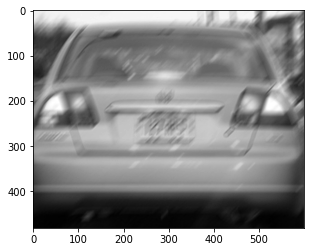

In [4]:

path = "../img/motion.jpeg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

img = np.float32(img)/255.0
plt.imshow(img, "gray")
input_img = img
img = blur_edge(img)
IMG = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
kernel_size = 65


#Function to create motion kernel, applied it on the input image and transform it back to spatial domain

In [5]:
def operation(ang, d, noise):

    psf = motion_kernel(ang, d, kernel_size)
    

    psf /= psf.sum()
    psf_pad = np.zeros_like(img)
    kh, kw = psf.shape
    psf_pad[:kh, :kw] = psf
    PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
    PSF2 = (PSF**2).sum(-1)
    iPSF = PSF / (PSF2 + noise)[...,np.newaxis]
    RES = cv2.mulSpectrums(IMG, iPSF, 0)
    res = cv2.idft(RES, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res = np.roll(res, -kh//2, 0)
    res = np.roll(res, -kw//2, 1)
    
    return res,psf

#dummy function for the trackbar update

In [6]:
def update(_):
    cv2.waitKey(200)

#Creating trackbar and displaying output along with kernel

In [7]:
#for motion 45, 22, 25
#for blur_img 0,42,25
#for blur_img3 12, 22, 22
imgDummy = np.zeros((1,512,3), np.uint8)
cv2.namedWindow("Parameter Adjustment")
cv2.moveWindow("Parameter Adjustment",700,20)
cv2.imshow('Parameter Adjustment',imgDummy)
cv2.createTrackbar('angle', "Parameter Adjustment", 46, 180, update)
cv2.createTrackbar("diameter", "Parameter Adjustment", 22, 50, update)
cv2.createTrackbar("SNR", "Parameter Adjustment", 25, 50, update)
output_img = np.zeros((img.shape), np.float32)
kernel = np.zeros((kernel_size,kernel_size), np.float32)
while True:
    k = cv2.waitKey(300) & 0xFF
    if k==27:
        break
    ang = np.deg2rad(360.0 -float(cv2.getTrackbarPos('angle', "Parameter Adjustment")))
    d = int(cv2.getTrackbarPos("diameter", "Parameter Adjustment"))
    if(d<3):
        d=3
    noise = 10**(-0.1*(float(cv2.getTrackbarPos("SNR", "Parameter Adjustment"))))
    imgr, psfr = operation(ang, d, noise)
    psfr = cv2.resize(psfr,(300,300))
    output_img = imgr
    kernel = psfr
    cv2.imshow("output",imgr)
    cv2.imshow("kernel", psfr)
    

cv2.waitKey()
cv2.destroyAllWindows()

: 

: 

#Comparing Output Image with Input Image

In [ ]:
figure, axis = plt.subplots(1,3, figsize=(20, 6))
axis[0].imshow(input_img, "gray")
axis[0].set_title("Input Image")

axis[1].imshow(kernel,"gray")
axis[1].set_title("PSF")

axis[2].imshow(output_img, "gray")

axis[2].set_title("Output Image")
axis[2].text(10,550,"Angle = 45° || Diameter = 22 || SNR = 25", color="green", backgroundcolor="white", size = 15)
plt.show()